### 03-regression

 - Runs logistic regression
 - Step 31 of methods
 - Edit correct cells, then run all

In [92]:
#imports
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from datetime import date
import math
from shapely import ops
import requests
import json

KEY = "" #add personal key here

functions complilation

In [14]:
def rename_columns(df, prefix):
    
    for col in df.columns:
        new_col = prefix + col.replace(" ", "")
        df = df.rename(columns={col: new_col})
    return df

In [78]:
def call_line(coordinates, fields, timestep):
    #perform API call
    url = 'https://api.tomorrow.io/v4/timelines?apikey=' + KEY
    
    payload = {
        'units':'metric', 
        'timesteps': timestep, 
        #'location': point, 
        'fields': fields, 
        'timezone': 'America/New_York',
        #'startTime': (now - timedelta(days=1)).isoformat(),
        #'endTime': now.isoformat(),
        'location': {
            'type': 'LineString',
            'coordinates': coordinates},
    }
    
    headers = {
    "Accept": "application/json",
    "Content-Type": "application/json"
    }
    
    response = requests.request("POST", url, json=payload, headers=headers)
    return response

In [79]:
def format_response(response):
    text = json.loads(response.text)
    timelines = text['data']['timelines']
    nest = timelines[0]['intervals'] #list - each element is a dictionary with startTime and values
    startTimes = pd.DataFrame(nest)['startTime']

    val = nest[0]['values'] #first time-stamp value
    values = pd.DataFrame(val, index=[0])

    #iterate through all time-stamps
    for i in range(1, len(startTimes)):
        val = nest[i]['values']
        df = pd.DataFrame(val, index=[i])
        values = pd.concat([values, df], axis=0)

    data = pd.concat([startTimes, values], axis=1)
    return data

#### START HERE
 - edit `date_list` to include all files that have been data processed
 - then run all cells

In [15]:
date_list = ['2021-06-20', '2021-06-21', '2021-06-23', '2021-06-26', '2021-06-27', '2021-06-28']

In [ ]:
df = pd.DataFrame(index=range(0,2))
for i in date_list:
    print(i)
    closures = gpd.read_file('/home/jovyan/work/data/a-closures/closures-agg/' + i + '.gpkg')
    slope = pd.read_csv(str('/home/jovyan/work/data/c-dem/slope/' + i + '.csv'))
    aspect = pd.read_csv('/home/jovyan/work/data/c-dem/aspect/' + i + '.csv')
    elev = pd.read_csv('/home/jovyan/work/data/c-dem/elevation/' + i + '.csv')
    
    slope = rename_columns(slope, 'slope')
    aspect = rename_columns(aspect, 'aspect')
    elev = rename_columns(elev, 'elev')
    
    data = closures.merge(slope, left_index=True, right_index=True)
    data = data.merge(aspect, left_index=True, right_index=True)
    data = data.merge(elev, left_index=True, right_index=True)
    
    #this leaves out all road segments that are within 5 km of the closure, to account for geotagging/chainage errors. 
    drop_list = []
    for index, row in data.iterrows():
        status = row['status']
        if status == 1:
            before = list(range(int(index-5),int(index)))
            after = list(range(int(index+1),int(index+6)))
            for i in before:
                if i < 0: 
                    pass
                elif data.iloc[i, data.columns.get_loc("status")] == 0:
                    drop_list.append(i) 
            for i in after:
                if i >= len(data): 
                    pass
                elif data.iloc[i, data.columns.get_loc("status")] == 0:
                    drop_list.append(i) 
    
    drop_array = np.unique(np.array(drop_list))
    data = data.drop(drop_array)
    df = df.append(data)
df = df.dropna(how='all')

In [137]:
data = pd.DataFrame(df)
y = np.asarray(data['status'])
#X = data[['precip_1d', 'elevMaximum', 'slopeVariance', 'slopeStandarddeviation', 'aspectMean']]
X = data.drop(['status','date', 'datetime', 'geometry', 'segment_id', 'road_id', 'elevpixelcount', 'aspectpixelcount', 'slopepixelcount', 'elevZoneID', 'aspectZoneID', 'slopeZoneID'], axis=1)
#X = data.drop(['status','date', 'datetime', 'geometry', 'segment_id', 'road_id', 'elevpixelcount', 'aspectpixelcount', 'slopepixelcount', 'elevZoneID', 'aspectZoneID', 'slopeZoneID', 'elevMedian', 'elevMean', 'aspectMean', 'aspectVariance', 'aspectMedianabsolutedeviation', 'slopeMaximum', 'slopeMedian', 'aspectMinimum'], axis=1)
#X = np.asarray(X.loc[:, X.columns != 'geometry'])
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.083818
         Iterations 16
                               Results: Logit
Model:                    Logit                Pseudo R-squared:     0.045   
Dependent Variable:       y                    AIC:                  410.1172
Date:                     2021-09-04 00:46     BIC:                  535.2733
No. Observations:         2184                 Log-Likelihood:       -183.06 
Df Model:                 21                   LL-Null:              -191.62 
Df Residuals:             2162                 LLR p-value:          0.70389 
Converged:                1.0000               Scale:                1.0000  
No. Iterations:           16.0000                                            
-----------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------

In [61]:
data2= data[['road_id','status','segment_id','datetime','precip_1d','slopeMinimum', 'aspectMedian', 'aspectMaximum', 'elevStandarddeviation']]
data2.sample(n=5)

,road_id,status,segment_id,datetime,precip_1d,slopeMinimum,aspectMedian,aspectMaximum,elevStandarddeviation
194,57.0,0.0,37.0,2021-06-21T12:29:59,0.0,1.469081,58.443527,360.00000,62.872677
175,13.0,1.0,176.0,2021-06-20T12:29:59,9.0,13.249520,268.264280,359.69687,37.035800
132,57.0,0.0,56.0,2021-06-28T12:29:59,0.0,7.450240,210.172300,336.80140,64.716500
122,28.0,0.0,81.0,2021-06-21T12:29:59,0.0,3.062798,185.387100,359.25595,18.401546
115,28.0,0.0,74.0,2021-06-21T12:29:59,0.0,0.503988,207.665800,357.87890,21.763947


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of logistic regression classifier on test set: 0.99


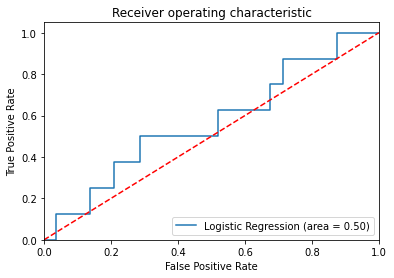

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### DATA

 - collects all the data for road 54

In [180]:
road = gpd.read_file('/home/jovyan/work/data/b-roads/road-split/54.gpkg')

slope = pd.read_csv('/home/jovyan/work/data/c-dem/slope/54.csv')
aspect = pd.read_csv('/home/jovyan/work/data/c-dem/aspect/54.csv')
elev = pd.read_csv('/home/jovyan/work/data/c-dem/elevation/54.csv')

slope = rename_columns(slope, 'slope')
aspect = rename_columns(aspect, 'aspect')
elev = rename_columns(elev, 'elev')

data = road.merge(slope, left_index=True, right_index=True)
data = data.merge(aspect, left_index=True, right_index=True)
data = data.merge(elev, left_index=True, right_index=True)

data = data.drop(['elevpixelcount', 'aspectpixelcount', 'slopepixelcount', 'elevZoneID', 'aspectZoneID', 'slopeZoneID'], axis=1)

In [181]:
#add precipitation data for segments 1-10 on road 54 in the next 24 hours. Only adding 10 segments' data at a time due to API call limit.
for index, row in data.head(10).iterrows():
    geom = row['geometry']
    geom_list = list(ops.linemerge(geom).coords)
    res = [list(ele) for ele in geom_list]
    response = call_line(res, ['precipitationIntensityAvg'], ['1h'])
    table = format_response(response)
    data.at[index, 'precip_1d'] = table.head(23).sum()['precipitationIntensityAvg']

In [185]:
data2 = data.drop(['road_id', 'date', 'status', 'segment_id', 'geometry', 'aspectMean'], axis=1)
data2 = data2.head(10)

#run prediction on fist 10 line segments
y_pred = logreg.predict(data2)
data3 = data.head(10)
data3['probability'] = y_pred
data3[['road_id', 'date', 'segment_id', 'geometry', 'precip_1d', 'probability']]

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,road_id,date,segment_id,geometry,precip_1d,probability
0,54,2021-07-12,1,"MULTILINESTRING ((79.21719 30.26079, 79.21749 ...",8.1075,0.0
1,54,2021-07-12,2,"MULTILINESTRING ((79.21827 30.25553, 79.21801 ...",8.1075,0.0
2,54,2021-07-12,3,"MULTILINESTRING ((79.21520 30.25862, 79.21484 ...",8.1075,0.0
3,54,2021-07-12,4,"MULTILINESTRING ((79.21620 30.25347, 79.21600 ...",18.5075,0.0
4,54,2021-07-12,5,"MULTILINESTRING ((79.21417 30.24601, 79.21422 ...",28.9077,0.0
5,54,2021-07-12,6,"MULTILINESTRING ((79.21905 30.24550, 79.21929 ...",28.9077,0.0
6,54,2021-07-12,7,"MULTILINESTRING ((79.21855 30.24397, 79.21830 ...",28.9077,0.0
7,54,2021-07-12,8,"MULTILINESTRING ((79.22114 30.24374, 79.22138 ...",28.9077,0.0
8,54,2021-07-12,9,"MULTILINESTRING ((79.22994 30.24412, 79.22943 ...",28.9077,0.0
9,54,2021-07-12,10,"MULTILINESTRING ((79.22076 30.24131, 79.22040 ...",28.9077,0.0
